last edited on November 5by Claire Valva
# Endless seasons for 40.5N spectral analysis

This notebook uses fft coefficient values (averaged for each season) to then create an arbitrarily long wave (ie. an endless summer etc) for later analysis. Currently known to work when the season wanted is a total of 10 by 10 observations (which is not quite endless). 

In [2]:
#use this instead? it might be faster? 
#maybe do numpy.reshape instead? after just running everything in line? download this later!
import numexpr as ne
from numba import jit

In [3]:
#import packages
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
from math import pi
import matplotlib.ticker as tck
import datetime
import pickle
from functions_forspectralanalysis import * #just in case I need it?

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:84: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


In [4]:
#load 2d transform from last time
file_Name = "transform_2d_oct2018"
file_pickle = open(file_Name,'rb') 
loaded_pickle = pickle.load(file_pickle)

In [5]:
d2_trans, seasons, d2_averages = loaded_pickle

## write function to extend season length and test

In [7]:
to_test = d2_trans[5]

In [20]:
#get longer array
wantedl = 90*4*100*2
zero_array = np.zeros(shape = 100, dtype = "complex128")
appended_zeros = [np.concatenate((zero_array, fftshift(entry), zero_array)) for entry in to_test]

#make up for changed dimensions
newdim = len(appended_zeros[5])
olddim = len(d2_trans[4][4])
mult = newdim/olddim

forifft = np.multiply(mult, appended_zeros)
forifft = [fftshift(entry) for entry in forifft]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


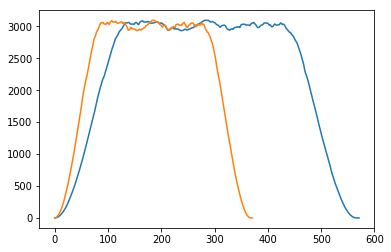

In [21]:
#try to see if that worked?
tested = np.fft.ifft2(forifft)
old = np.fft.ifft2(d2_trans[5])

plt.clf()
plt.plot(tested[12])
plt.plot(old[12])
#plt.plot(tested[50])
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


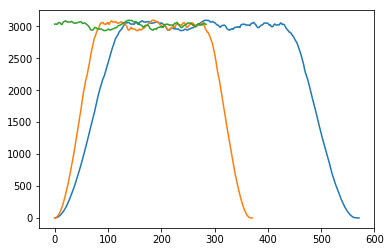

In [22]:
#now test that should chop off the first and second half
total_len = len(tested[12])
sixth = total_len/4
end = total_len - sixth
adjusted_tested = [[entry[i] for i in range(len(entry)) if i > sixth and i < end] 
                   for entry in tested]

#now see it again
plt.clf()
plt.plot(tested[12])
plt.plot(old[12])
plt.plot(adjusted_tested[12])
#plt.plot(tested[50])
plt.show()

In [128]:
##write that all up into a neat function


def ext_ifft(length, input_array):
    #add the zeros onto each end
    zero_array = np.zeros(shape = length, dtype = "complex128")
    appended_zeros = [np.concatenate((zero_array, fftshift(entry), zero_array)) 
                      for entry in input_array]
    
    #make up for the formulat multiplying for array length
    newdim = len(appended_zeros[5])
    olddim = len(input_array[0])
    mult = newdim/olddim
    forifft = np.multiply(mult,appended_zeros)
    forifft = [fftshift(entry) for entry in forifft]
    
    #apply ifft
    iarr = np.fft.ifft2(forifft)
    
    #cut off the windowed parts for later plotting
    total_len = len(iarr[12])
    fourth = int(total_len/4)
    end = int(total_len - fourth)
    
    adjusted_tested = [entry[fourth:end] for entry in iarr]
    
    return adjusted_tested

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


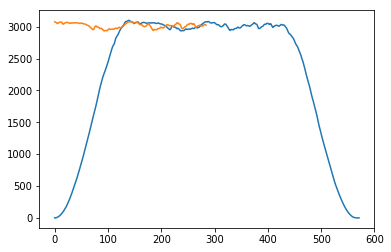

In [129]:
#test the function vs. what was done before
func_test = ext_ifft(length = wantedl, input_array = to_test)

#did it woork.. it woooorked
plt.clf()
plt.plot(tested[15])
plt.plot(adjusted_tested[15])
plt.show()

## Apply extended simulation to seasonal averages

In [130]:
#apply ifft
extended_seasons = np.real([ext_ifft(length=wantedl, input_array = entry) 
                            for entry in d2_averages])


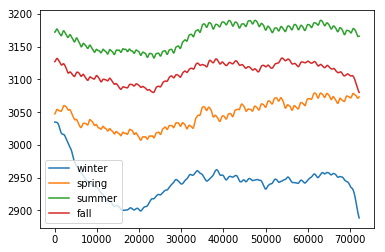

In [131]:
#compare to see if difference in geopotential height stayed
plt.clf()
plt.plot(extended_seasons[0][13], label = seasons[0])
plt.plot(extended_seasons[1][13], label = seasons[1])
plt.plot(extended_seasons[2][13], label = seasons[2])
plt.plot(extended_seasons[3][13], label = seasons[3])
plt.legend()    
plt.show()

well winter is.. something 

In [118]:
#get mean of each season
mean_seasons = [np.average(entry) for entry in extended_seasons]

### sort the longitudes into buckets

In [119]:
#set lists of longitude sections as strings for labeling
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'

lon_sections = [lon_1, lon_2, lon_3, lon_4]

In [120]:
def lon_sort(lon):
    #define function to sort into longitude sections
    clon_1 = lon >= 50 and lon <= 140
    clon_2 = lon <= 50 or lon >= 320
    clon_3 = lon >= 230 and lon <= 320
    clon_4 = lon >= 140 and lon <= 230

    if clon_1 == True:
        return(1)
    elif clon_2 == True:
        return(2)
    elif clon_3 == True:
        return(3)
    elif clon_4 == True:
        return(4)
    else:
        return("lon sorting error")

In [121]:
#get beginning and end of each index
lon_index_sort = [[i for i in range(240) if lon_sort(i*1.5) == j + 1] for j in range(4)]
beginning_lons = [entry[i] for entry in lon_index_sort]
end_lons = [entry[len(entry) - 1] for entry in lon_index_sort]

#now slice up the results
#note that this will be heirarchy of season > lon_section
lon_sectioned = [[np.array(entry[beginning_lons[j]:end_lons[j]]) for j in range(4)]
                       for entry in np.array(extended_seasons)]
mean_lons = [[np.average(entry) for entry in season] for season in lon_sectioned]

## Make histograms

In [122]:
flatten = lambda l: [item for sublist in l for item in sublist]

<Figure size 432x288 with 0 Axes>

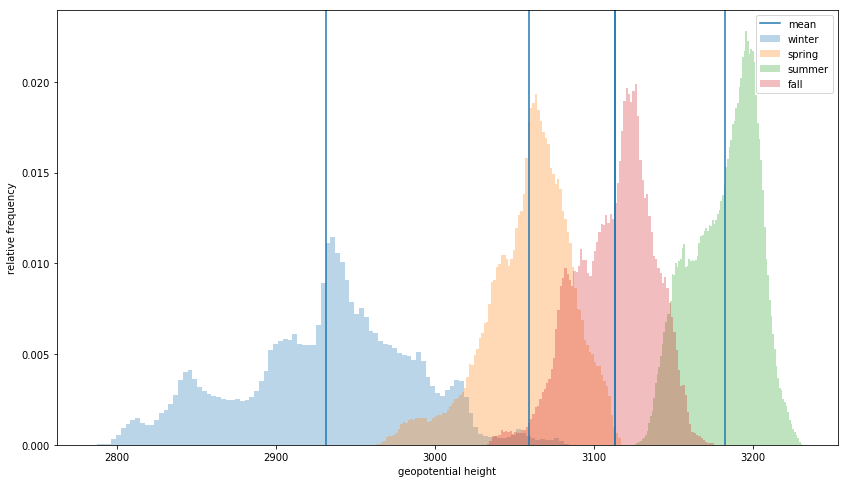

In [136]:
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    plt.hist(flatten(extended_seasons[i]), label = seasons[i], 
             bins = 100, density = True, alpha = 0.3)
    plt.axvline(mean_seasons[i])
plt.xlabel("geopotential height")
plt.axvline(mean_seasons[i], label = "mean")
plt.ylabel("relative frequency")
plt.legend()
plt.show()

### also do for longitude sections

In [137]:
#would be most ideal to do a split plot with actual vs. lon sectioned on each side
#difference in magnitude must likely a result of the previous processing (see window application)

<Figure size 432x288 with 0 Axes>

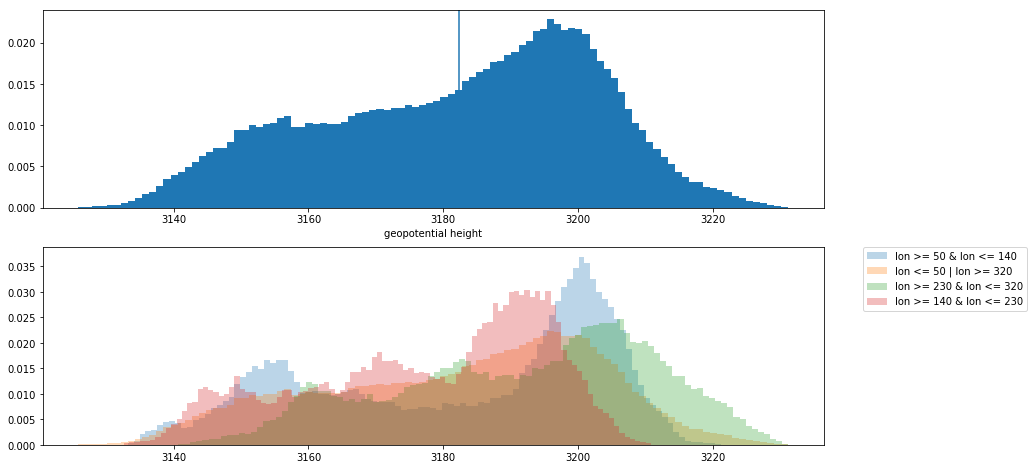

In [148]:
i = 2
to_section = lon_sectioned[i]

plt.clf()
plt.figure(figsize = (14,8))


plt.subplot(2, 1, 1)
plt.title(seasons[i])
plt.hist(flatten(extended_seasons[i]), 
         bins = 100, density = True)
plt.axvline(mean_seasons[i])
plt.xlabel('geopotential height')

plt.subplot(2, 1, 2)
for j in range(4):
    plt.hist(flatten(to_section[j]), bins = 100, 
             density = True, alpha = 0.3,
             label = lon_sections[j])
    #plt.axvline(mean_lons[i][j])

#plt.axvline(mean_lons[i][j], label = "mean")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()